In [1]:
import copy
import glob
import pickle
import warnings
from datetime import datetime, timedelta
from itertools import product
import joblib
import os

import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader
import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
# np.random.seed(42)
import pandas as pd
import shapely.geometry as sgeom
import xarray as xr
from scipy import stats
from scipy.spatial.distance import cdist
from shapely import geometry
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# import cluster_analysis, narm_analysis, som_analysis

In [2]:
import keras
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, AveragePooling2D, Dropout
from keras.utils import to_categorical
from keras.layers import LeakyReLU
from keras.layers import ReLU
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

# import visualkeras
# import tensorflow as tf

# ## GLOBAL SEED ##    
# np.random.seed(42)
# tf.random.set_seed(42)

2023-01-04 18:29:45.205806: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


KeyboardInterrupt: 

# Load data

## Weather regimes

In [3]:
week1_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week1_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week2_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week2_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week3_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week3_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week4_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week4_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week5_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week5_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week6_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week6_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week7_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week7_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week8_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week8_wr_v3.csv',\
                      index_col = 0, parse_dates = True)
week9_wr = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/week9_wr_v3.csv',\
                      index_col = 0, parse_dates = True)

df_wr = pd.concat([week1_wr,week2_wr,week3_wr,week4_wr,week5_wr,week6_wr,week7_wr,week8_wr,week9_wr],axis=1)
df_wr.columns = ['week1','week2','week3','week4','week5','week6','week7','week8','week9']

df_wr_2 = pd.read_csv('/glade/work/jhayron/Weather_Regimes/weekly_wr/weekly_wr_mean_geop_v3.csv',
                     index_col=0,parse_dates=True)

df_wr_2 = df_wr_2.dropna()
df_wr = df_wr.dropna()

## Input Variables

In [4]:
variables = ['z500']
name_var = ['z500']
units = ['m2/s2']


In [5]:
dic_vars = {}
for var_short, variable,unit in zip(name_var,variables,units):
# for var_short, variable,unit in zip(['sst'],['sst'],['K']):
    path_w_anoms = '/glade/work/jhayron/Weather_Regimes/weekly_anomalies/'
    week1_anoms = xr.open_dataset(f'{path_w_anoms}week1_{variable}_anoms_v3.nc')
    # week1_anoms = week1_anoms.sel(time=df_wr_2.index)
    if variable=='z500':
        week1_anoms = week1_anoms.where(week1_anoms.lat>-30,drop=True)
    # week1_anoms = week1_anoms.sel(time=df_wr.index)
    week1_anoms = week1_anoms.sel(time=df_wr_2.index)
    dic_vars[variable] = week1_anoms
    
    ##########PLOT#####################
#     fig = plt.figure(figsize=(9,7))
#     ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=-90+360))
    
#     #     vmax = np.round(np.percentile(abs(week1_anoms[f'{var_short}_anomalies'].values[0]),100),0)
#     #     vmin = -np.round(np.percentile(abs(week1_anoms[f'{var_short}_anomalies'].values[0]),100),0)
    
#     vmax = np.round(np.percentile(abs(week1_anoms[f'{var_short}_anomalies'].values[0]),100),0)
#     vmin = -np.round(np.percentile(abs(week1_anoms[f'{var_short}_anomalies'].values[0]),100),0)
#     # print(vmax,vmin)
#     cs = plt.pcolormesh(week1_anoms.lon,week1_anoms.lat,\
#         week1_anoms[f'{var_short}_anomalies'].values[0],cmap='seismic',
#         transform=ccrs.PlateCarree(),vmin=vmin,vmax=vmax)
#     ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
#     ax.margins(x=0, y=0)

#     # ax.set_extent([-179, 179, 10, 90], crs=ccrs.PlateCarree())
#     if variable!='st':
#         plt.title(variable.upper().replace('_','-'))
#     else:
#         plt.title(variable.upper().replace('_','-').replace('ST','TS'))
#     if 'region' in variable:
#         cbar_ax = fig.add_axes([0.25, 0.19, 0.5, 0.0175])
#     else:
#         cbar_ax = fig.add_axes([0.25, 0.3, 0.5, 0.0175])
#     # ticks_1 = [-80, -40, 0, 40, 80]
#     cbar = fig.colorbar(cs, cax=cbar_ax,
#                         orientation='horizontal', extend='both')
#     cbar.ax.tick_params(labelsize=14)
#     cbar.set_label(unit, fontsize=14)
#     plt.savefig(f'/glade/u/home/jhayron/WeatherRegimes/Figures/MapsVariables/{variable}_anomalies_v2.png',bbox_inches='tight')
#     plt.close('all')

# Build models

# Train

In [6]:
## Start with a simple net, 2 convolutional layers, 2 dense layers
## 8 filters

In [85]:
def create_model(activation_conv = LeakyReLU()):
    num_classes = 4
    # alpha=0.01
    ks = 3
    ps = 5
    st = 3
    do = 0.4
    md = 16
    nfilters=32
    padding_type = 'same'
    model = Sequential()
    model.add(Conv2D(nfilters, kernel_size=(ks, ks),activation=activation_conv,
        input_shape=X_train.shape[1:],padding=padding_type))
    model.add(AveragePooling2D((ps, ps),padding=padding_type,strides=st))
    model.add(Dropout(do))
    model.add(Conv2D(nfilters*2, (ks, ks), activation=activation_conv,padding=padding_type))
    model.add(AveragePooling2D((ps, ps),padding=padding_type,strides=st))
    model.add(Dropout(do))


    model.add(Flatten())
    model.add(Dense(num_classes*md*md, activation=activation_conv))
    model.add(Dropout(do))
    model.add(Dense(num_classes*md, activation=activation_conv))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, 
        optimizer=keras.optimizers.Adam(lr=0.00001),metrics=['accuracy'])
    return model


In [86]:
path_models = '/glade/work/jhayron/Weather_Regimes/models/CNN/weights_variables_v5/'

********************************************************************************************
z500
********************************************************************************************
week3
Epoch 1/200
140/140 [==============================] - 5s 30ms/step - loss: 1.3638 - accuracy: 0.3303 - val_loss: 1.3512 - val_accuracy: 0.3526
Epoch 2/200
140/140 [==============================] - 3s 22ms/step - loss: 1.3242 - accuracy: 0.3586 - val_loss: 1.3419 - val_accuracy: 0.3483
Epoch 3/200
140/140 [==============================] - 3s 25ms/step - loss: 1.2942 - accuracy: 0.4065 - val_loss: 1.3371 - val_accuracy: 0.3483
Epoch 4/200
140/140 [==============================] - 4s 29ms/step - loss: 1.2901 - accuracy: 0.4169 - val_loss: 1.3401 - val_accuracy: 0.3483
Epoch 5/200
140/140 [==============================] - 4s 29ms/step - loss: 1.2568 - accuracy: 0.4264 - val_loss: 1.3397 - val_accuracy: 0.3526
Epoch 6/200
140/140 [==============================] - 4s 29ms/step - loss: 1.2488 

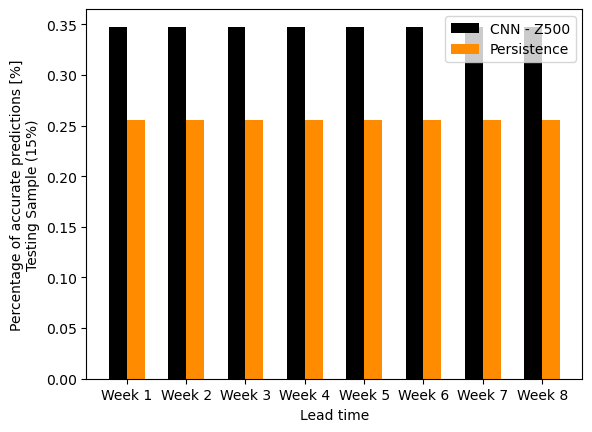

In [87]:
dic_metrics = {}

for var_short, variable in zip(name_var,variables):
    print('********************************************************************************************')
    print(variable)
    print('********************************************************************************************')
    loss_weeks_model = []
    loss_weeks_persistence = []
    acc_weeks_model = []
    acc_weeks_persistence = []

    for week in ['week3']:
        print(week)
        #### ORGANIZE DATA ####
        week_output_wr = df_wr_2[week].values.astype(int)
        # Make Y categorical
        serie_wr_categorical = to_categorical(week_output_wr,num_classes=4)
        
        week1_anoms = copy.deepcopy(dic_vars[variable])
        
        # # Scale by min-max
        Min = week1_anoms[f'{var_short}_anomalies'].min(dim='time')
        Max = week1_anoms[f'{var_short}_anomalies'].max(dim='time')
        scaled_x = (week1_anoms[f'{var_short}_anomalies']) / (Max - Min)

        indices = np.arange(len(serie_wr_categorical))
        #Reshape X
        scaled_x = scaled_x.data.reshape(-1, scaled_x.shape[1],scaled_x.shape[2], 1)

        indices_train = np.where(df_wr_2.week2.index.year<=2001)[0]
        indices_val = np.where((df_wr_2.week2.index.year>2001)&(df_wr_2.week2.index.year<=2010))[0]
        indices_test = np.where(df_wr_2.week2.index.year>2010)[0]

        X_test = scaled_x[indices_test]
        y_test = serie_wr_categorical[indices_test]

        X_train = scaled_x[indices_train]
        y_train = serie_wr_categorical[indices_train]

        X_val = scaled_x[indices_val]
        y_val = serie_wr_categorical[indices_val]

        wr_persistence = df_wr_2.week1.values.astype(int)[indices_test]
        serie_wr_persistence_categorical = to_categorical(wr_persistence)

        #### TRAIN ####

        keras.backend.clear_session()
        model = create_model()
        # aaaa
        batch_size = 16
        epochs = 200

        earlystop = EarlyStopping(monitor='val_loss', patience=5)
        try:
            os.mkdir(f'{path_models}{variable}')
        except: pass
        filepath = f'{path_models}{variable}/model_{week}_v5.h5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, 
                                     mode='auto',save_weights_only=False)
        model.fit(X_train, y_train, batch_size=batch_size,\
            epochs=epochs,verbose=1,validation_data=(X_val, y_val), callbacks=[checkpoint,earlystop])

        #### EVAL ####

        model.load_weights(filepath)
        model.save(filepath)
        metrics_model = model.evaluate(x=X_test,y=y_test)
        acc_temp = metrics_model[1]
        loss_temp = metrics_model[0]
        acc_persistence = accuracy_score(y_test,serie_wr_persistence_categorical)
        loss_persistence = log_loss(y_test,serie_wr_persistence_categorical)
        print('loss/acc model')
        print(metrics_model)
        print('loss/acc persistence')
        print([loss_persistence,acc_persistence])

        loss_weeks_model.append(loss_temp)
        loss_weeks_persistence.append(loss_persistence)
        acc_weeks_model.append(acc_temp)
        acc_weeks_persistence.append(acc_persistence)
    
    ### PLOT BARS ###
    plt.bar(np.arange(8),acc_weeks_model,width=-0.3,align='edge',label=f'CNN - {variable.upper()}',color='k')
    plt.bar(np.arange(8),acc_weeks_persistence,width=0.3,align='edge',label='Persistence',color='darkorange')
    plt.legend()
    plt.ylabel('Percentage of accurate predictions [%]\nTesting Sample (15%)')
    plt.xticks(np.arange(8),['Week 1','Week 2','Week 3','Week 4','Week 5','Week 6','Week 7','Week 8'])
    plt.xlabel('Lead time')
    path_figures = '/glade/u/home/jhayron/WeatherRegimes/Figures/Variables/'
    # plt.savefig(f'{path_figures}{variable}_SvP_v2.png',bbox_inches='tight')
    plt.show()
    plt.close('all')
    
    ### SAVE METRICS ###
    
    df_metrics = pd.DataFrame(np.array([acc_weeks_model,acc_weeks_persistence,loss_weeks_model,loss_weeks_persistence]).T,
            columns = ['acc_model','acc_persistence','loss_model','loss_persistence'])
    dic_metrics[variable] = df_metrics
    # aaaa

In [88]:
accuracy_score(model.predict(X_test).argmax(axis=1),y_test.argmax(axis=1))

0.34774774774774775

In [89]:
balanced_accuracy_score(model.predict(X_test).argmax(axis=1),y_test.argmax(axis=1))

0.3426168554506986

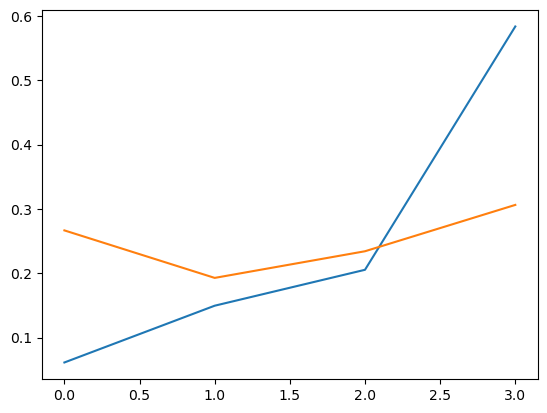

In [90]:
y_predicted_test = model.predict(X_test).argmax(axis=1)
# plt.hist(y_predicted_test,density=True)
hist = np.histogram(y_predicted_test,bins=4)[0]/np.sum(np.histogram(y_predicted_test,bins=4)[0])
hist_real = np.histogram(y_test.argmax(axis=1),bins=4)[0]/np.sum(np.histogram(y_test.argmax(axis=1),bins=4)[0])
plt.plot(hist)
plt.plot(hist_real)

In [91]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 360, 32)      320       
_________________________________________________________________
average_pooling2d (AveragePo (None, 40, 120, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 120, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 120, 64)       18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 40, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 40, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 35840)             0